In [1]:
import pandas as pd
from nltk.corpus import stopwords
import time
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.classification import accuracy_score, log_loss
from collections import defaultdict, Counter
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from scipy.sparse import vstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.simplefilter('ignore')
from mlxtend.classifier import StackingClassifier

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
data = pd.read_csv("training_variants")

In [4]:
data

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


In [5]:
data.shape

(3321, 4)

In [6]:
data_text = pd.read_csv("Training_text", sep = "\|\|", names = ["ID", "Text"])

In [7]:
data_text = data_text.drop(0, axis = 0)

In [8]:
data_text = data_text.reset_index(drop = True)

In [9]:
data_text.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [10]:
data_text.shape

(3321, 2)

In [11]:
!pip install nltk
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /Users/shyam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stop_words = set(stopwords.words('english'))


def preprocessing_nlp(totaltexts, inx, clm):
    if type(totaltexts) is not int:
        string = ""
        totaltexts = re.sub('[^a-zA-Z0-9\n]', ' ', totaltexts)
        totaltexts = re.sub('\s+',' ', totaltexts)
        totaltexts = totaltexts.lower()
        for word in totaltexts.split():
            if not word in stop_words:
                string += word + " "
        
        data_text[clm][inx] = string

In [13]:
strt_time = time.clock()
for inx, rw in data_text.iterrows():
    if type(rw['Text']) is str:
        preprocessing_nlp(rw['Text'], inx, 'Text')
    else:
        print("there is no text description for id:",inx)
print('Total time for preprocessing :',time.clock() - strt_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Total time for preprocessing : 30.836479999999998 seconds


In [14]:
data_text = data_text.drop(["ID"], axis = 1)

In [15]:
Final_Data = pd.concat([data, data_text], axis = 1)

In [16]:
Final_Data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [17]:
for inx, txtinfo in Final_Data.iterrows():
    if type(txtinfo["Text"]) is not str:
        print(inx)

1109
1277
1407
1639
2755


In [18]:
for inx, txtinfo in Final_Data.iterrows():
    if type(txtinfo["Text"]) is not str:
        Final_Data.drop(inx, axis = 0, inplace = True)

In [19]:
Final_Data_Label = Final_Data["Class"]

In [20]:
Final_Data = Final_Data.drop(["Class"], axis = 1)

In [21]:
Final_Data.head()

,ID,Gene,Variation,Text
0,0,FAM58A,Truncating Mutations,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,abstract background non small cell lung cancer...
2,2,CBL,Q249E,abstract background non small cell lung cancer...
3,3,CBL,N454D,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,oncogenic mutations monomeric casitas b lineag...


In [22]:
Final_Data = pd.concat([Final_Data, Final_Data_Label], axis = 1)

# Final data

In [23]:
Final_Data_Label.head()

0    1
1    2
2    2
3    3
4    4
Name: Class, dtype: int64

In [24]:
Final_Data["Gene"] = Final_Data["Gene"].str.replace("\s+", "_")
Final_Data["Variation"] = Final_Data["Variation"].str.replace("\s+", "_")

In [25]:
Final_Data.head()

,ID,Gene,Variation,Text,Class
0,0,FAM58A,Truncating_Mutations,cyclin dependent kinases cdks regulate variety...,1
1,1,CBL,W802*,abstract background non small cell lung cancer...,2
2,2,CBL,Q249E,abstract background non small cell lung cancer...,2
3,3,CBL,N454D,recent evidence demonstrated acquired uniparen...,3
4,4,CBL,L399V,oncogenic mutations monomeric casitas b lineag...,4


# Spliting data into train, test, and cross validation 

In [26]:
X_Train, TestData, Y_Train, TestLabels = train_test_split(Final_Data, Final_Data_Label, stratify=Final_Data_Label, test_size=0.2)
TrainData, CV_Data, TrainDataLabels, CV_Data_Labels = train_test_split(X_Train, Y_Train, stratify=Y_Train, test_size=0.2)

In [27]:
X_Train.shape, TestData.shape, Y_Train.shape, TestLabels.shape

((2652, 5), (664, 5), (2652,), (664,))

In [28]:
print('Total train data :', TrainData.shape[0])
print('Total test data:', TestData.shape[0])
print('Total cross validation data:', CV_Data.shape[0])

Total train data : 2121
Total test data: 664
Total cross validation data: 531


In [29]:
traindata_dist = TrainData["Class"].value_counts().sort_index()
cvdata_dist = CV_Data["Class"].value_counts().sort_index()
testdata_dist = TestData["Class"].value_counts().sort_index()

In [30]:
#Sorting 
TrainData_distribution_sorted = sorted(traindata_dist.items(), key = lambda d: d[1], reverse = True)
CVData_distribution_sorted = sorted(cvdata_dist.items(), key = lambda d: d[1], reverse = True)
TestData_distribution_sorted = sorted(testdata_dist.items(), key = lambda d: d[1], reverse = True)

# Response Coding

In [31]:
def Response_coding_features(alp, feat, df):
    
    count_value = TrainData[feat].value_counts()
    rwclm_values = dict()
    
    for i, deno in count_value.items():
        vector = []
        for k in range(1, 10):
            cls_cnt = TrainData.loc[(TrainData["Class"]==k) & (TrainData[feat]==i)]
            vector.append((cls_cnt.shape[0] + 10*alp)/deno + (90*alp))    
        rwclm_values[i] = vector
    return rwclm_values


def Response_values_coded(alp, feat, df):
    get_rwclm_values = Response_coding_features(alp, feat, df)
    get_count_values = TrainData[feat].value_counts()
    get_values_feat = []
    for inx, rw in df.iterrows():
        if rw[feat] in dict(get_count_values).keys():
            get_values_feat.append(get_rwclm_values[rw[feat]])
        else:
            get_values_feat.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return get_values_feat

In [32]:
total_genes_unique = TrainData["Gene"].value_counts()
print("Total unique genes : "+ str(total_genes_unique.shape[0]))
print(total_genes_unique.head(10))

Total unique genes : 233
BRCA1     164
TP53       98
EGFR       96
PTEN       84
BRCA2      81
BRAF       67
KIT        63
ERBB2      54
PDGFRA     43
ALK        39
Name: Gene, dtype: int64


#Gene Response Coding

In [33]:
alpha = 1

response_coding_train_gene = np.array(Response_values_coded(alpha, "Gene", TrainData))
response_coding_test_gene = np.array(Response_values_coded(alpha, "Gene", TestData))
response_coding_cv_gene = np.array(Response_values_coded(alpha, "Gene", CV_Data))

In [34]:
response_coding_train_gene = (response_coding_train_gene.T/response_coding_train_gene.sum(axis=1)).T
response_coding_test_gene = (response_coding_test_gene.T/response_coding_test_gene.sum(axis=1)).T
response_coding_cv_gene = (response_coding_cv_gene.T/response_coding_cv_gene.sum(axis=1)).T 

In [35]:
print("Total size of response-encoded genes in train data = "+str(response_coding_train_gene.shape))
print("Total size of response-encoded genes in test data = "+str(response_coding_test_gene.shape))
print("Total size of response-encoded genes in CV data = "+str(response_coding_cv_gene.shape))

Total size of response-encoded genes in train data = (2121, 9)
Total size of response-encoded genes in test data = (664, 9)
Total size of response-encoded genes in CV data = (531, 9)


In [36]:
vectorizerGene = CountVectorizer()
count_vec_train_gene= vectorizerGene.fit_transform(TrainData['Gene'])
count_vec_test_gene = vectorizerGene.transform(TestData['Gene'])
count_vec_cv_gene = vectorizerGene.transform(CV_Data['Gene'])

In [37]:
print("Total size of one-hot encoded genes in train data = "+str(count_vec_train_gene.shape))
print("Total size of one-hot encoded genes in test data = "+str(count_vec_test_gene.shape))
print("Total size of one-hot encoded genes in CV data = "+str(count_vec_cv_gene.shape))

Total size of one-hot encoded genes in train data = (2121, 232)
Total size of one-hot encoded genes in test data = (664, 232)
Total size of one-hot encoded genes in CV data = (531, 232)


In [38]:
alpha = [10 ** x for x in range(-5, 1)]

log_loss_for_cv = []
for i in alpha:
    clfs = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clfs.fit(count_vec_train_gene, TrainDataLabels)
    cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
    #this is a cross-validation
    cal_clfs.fit(count_vec_train_gene, TrainDataLabels)
    predicted_y = cal_clfs.predict_proba(count_vec_cv_gene)
    log_loss_for_cv.append(log_loss(CV_Data_Labels, predicted_y, labels=clfs.classes_))
    print("For alpha value "+str(i)+" CV log loss is = "+str(log_loss(CV_Data_Labels, predicted_y, labels=clfs.classes_)))

For alpha value 1e-05 CV log loss is = 1.2187088780908029
For alpha value 0.0001 CV log loss is = 1.190734787442997
For alpha value 0.001 CV log loss is = 1.2321810933817987
For alpha value 0.01 CV log loss is = 1.357603893539122
For alpha value 0.1 CV log loss is = 1.4683707371109722
For alpha value 1 CV log loss is = 1.4951638846447401


In [39]:
bestvalue= alpha[np.argmin(log_loss_for_cv)]
clfs = SGDClassifier(alpha=bestvalue, penalty='l2', loss='log', random_state=42)
clfs.fit(count_vec_train_gene, TrainDataLabels)
cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
cal_clfs.fit(count_vec_train_gene, TrainDataLabels)

predict_train = cal_clfs.predict_proba(count_vec_train_gene)
print('Best alpha values: ', bestvalue, "the train log loss =:",log_loss(TrainDataLabels, predict_train, labels=clfs.classes_))

predict_cv = cal_clfs.predict_proba(count_vec_cv_gene)
print('Best alpha values: ', bestvalue, "the CV log loss =:",log_loss(CV_Data_Labels, predict_cv, labels=clfs.classes_))

predict_test = cal_clfs.predict_proba(count_vec_test_gene)
print('Best alpha values: ', bestvalue, "the test log loss =:",log_loss(TestLabels, predict_test, labels=clfs.classes_))

Best alpha values:  0.0001 the train log loss =: 1.006738928222377
Best alpha values:  0.0001 the CV log loss =: 1.190734787442997
Best alpha values:  0.0001 the test log loss =: 1.1870087982377482


In [40]:
gene_commontest = TestData[TestData["Gene"].isin(TrainData["Gene"])].shape[0]
gene_commoncv = CV_Data[CV_Data["Gene"].isin(TrainData["Gene"])].shape[0]
print("Percentage for common data in between train and test data= "+str(np.round((gene_commontest/TestData.shape[0])*100, 2))+"%")

print("Percentage  for common data in between train and cv data = "+str(np.round((gene_commoncv/CV_Data.shape[0])*100, 2))+"%")


Percentage for common data in between train and test data= 96.84%
Percentage  for common data in between train and cv data = 97.36%


#Response coding for variatons

In [41]:
Total_variation_unique = TrainData["Variation"].value_counts()
print("Total variations unique = "+str(Total_variation_unique.shape[0]))
print(Total_variation_unique.head(10))

Total variations unique = 1926
Truncating_Mutations    54
Deletion                50
Amplification           49
Fusions                 22
Q61R                     3
Q61L                     3
Overexpression           3
Q61H                     3
T167A                    2
G13V                     2
Name: Variation, dtype: int64


In [42]:
alpha = 1

response_coding_train_variation = np.array(Response_values_coded(alpha, "Variation", TrainData))

response_coding_test_variation = np.array(Response_values_coded(alpha, "Variation", TestData))

response_coding_cv_variation = np.array(Response_values_coded(alpha, "Variation", CV_Data))

In [43]:
train_variation_feature_responseCoding = (response_coding_train_variation.T/response_coding_train_variation.sum(axis=1)).T
test_variation_feature_responseCoding = (response_coding_test_variation.T/response_coding_test_variation.sum(axis=1)).T
cv_variation_feature_responseCoding = (response_coding_cv_variation.T/response_coding_cv_variation.sum(axis=1)).T  

In [44]:
print("Total size of response encoded train data = "+str(response_coding_train_variation.shape))
print("Total size of response encoded test data = "+str(response_coding_test_variation.shape))
print("Total size of response encoded CV data = "+str(response_coding_cv_variation.shape))

Total size of response encoded train data = (2121, 9)
Total size of response encoded test data = (664, 9)
Total size of response encoded CV data = (531, 9)


In [45]:
vectorizerVariations = CountVectorizer()
count_vec_train_variation = vectorizerVariations.fit_transform(TrainData['Variation'])
count_vec_test_variation = vectorizerVariations.transform(TestData['Variation'])
count_vec_cv_variation = vectorizerVariations.transform(CV_Data['Variation'])

In [46]:
print("one-hot encoded in train data = "+str(count_vec_train_variation.shape))
print("one-hot encoded in test data = "+str(count_vec_test_variation.shape))
print("one-hot encoded in CV data = "+str(count_vec_cv_variation.shape))

one-hot encoded in train data = (2121, 1950)
one-hot encoded in test data = (664, 1950)
one-hot encoded in CV data = (531, 1950)


In [47]:
alpha = [10 ** x for x in range(-5, 1)]

log_loss_for_cv = []
for i in alpha:
    clfs = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clfs.fit(count_vec_train_variation, TrainDataLabels)
    cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
    cal_clfs.fit(count_vec_train_variation, TrainDataLabels)
    predicted_y = cal_clfs.predict_proba(count_vec_cv_variation)
    log_loss_for_cv.append(log_loss(CV_Data_Labels, predicted_y, labels=clfs.classes_))
    print("For alpha value "+str(i)+" CV log loss = "+str(log_loss(CV_Data_Labels, predicted_y, labels=clfs.classes_)))

For alpha value 1e-05 CV log loss = 1.718485904771292
For alpha value 0.0001 CV log loss = 1.710687024533485
For alpha value 0.001 CV log loss = 1.7118671357370066
For alpha value 0.01 CV log loss = 1.726893836235714
For alpha value 0.1 CV log loss = 1.7322563938078401
For alpha value 1 CV log loss = 1.7318515468641742


In [48]:
bestvalue = alpha[np.argmin(log_loss_for_cv)]
clfs = SGDClassifier(alpha=bestvalue, penalty='l2', loss='log', random_state=42)
clfs.fit(count_vec_train_variation, TrainDataLabels)
cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
cal_clfs.fit(count_vec_train_variation, TrainDataLabels)

predict_train = cal_clfs.predict_proba(count_vec_train_variation)
print('Best alpha values = ', bestvalue, "the train log loss =:",log_loss(TrainDataLabels, predict_train, labels=clfs.classes_))

predict_cv = cal_clfs.predict_proba(count_vec_cv_variation)
print('Best alpha values= ', bestvalue, "the CV log loss =:",log_loss(CV_Data_Labels, predict_cv, labels=clfs.classes_))

predict_test = cal_clfs.predict_proba(count_vec_test_variation)
print('Best alpha values = ', bestvalue, "the test log loss =:",log_loss(TestLabels, predict_test, labels=clfs.classes_))

Best alpha values =  0.0001 the train log loss =: 0.788877568626622
Best alpha values=  0.0001 the CV log loss =: 1.710687024533485
Best alpha values =  0.0001 the test log loss =: 1.7011600444152835


In [49]:
test_common_variation = TestData[TestData["Variation"].isin(TrainData["Variation"])].shape[0]
cv_common_variation = CV_Data[CV_Data["Variation"].isin(TrainData["Variation"])].shape[0]
print("Percentage for common variations between train and test data = "+str(np.round((test_common_variation/TestData.shape[0])*100, 2))+"%")
print("Percentage for common variations between train and cv data = "+str(np.round((cv_common_variation/CV_Data.shape[0])*100, 2))+"%")

Percentage for common variations between train and test data = 9.79%
Percentage for common variations between train and cv data = 11.49%


In [50]:
dicttext = defaultdict(int)
for inx, rw in TrainData.iterrows():
    for word in rw['Text'].split():
        dicttext[word] += 1
print("Unique words in text train data = "+str(len(dicttext.keys())))

Unique words in text train data = 125443


In [51]:
def Textword(text_ext):
    dicttext = defaultdict(int)
    for inx, rw in text_ext.iterrows():
        for word in rw['Text'].split():
            dicttext[word] += 1
    return dicttext

In [52]:
list_dic = []
for i in range(1,10):
    text_ext = TrainData[TrainData['Class']==i]
    print(text_ext)
    list_dic.append(Textword(text_ext))
dict_total = Textword(TrainData)

        ID      Gene                                          Variation  \
1301  1301      MLH1                                              R265S   
1096  1096    MAP3K1                                             T779fs   
2804  2804     BRCA2                                             R2659T   
2592  2592     BRCA1                                             V1838E   
2905  2905       NF2                                              L535P   
2184  2184      PTEN                                              G129A   
1036  1036      TSC2                                           Deletion   
1304  1304      MLH1                                              A111P   
1056  1056      TSC2                                               E75G   
1273  1273    PIK3R2                                              D557H   
955    955     RBM10                                           Deletion   
913    913    PDGFRA                                              W349C   
2805  2805     BRCA2     

        ID     Gene                                Variation  \
339    339     ROS1                                   E1935G   
3069  3069   NOTCH1                                 V1605del   
855    855     ABL1                                    L384M   
179    179     EGFR                                    G857E   
733    733    ERBB2                                    V773A   
3281  3281      RET                                    C634W   
1224  1224   PIK3CB                                  Fusions   
2104  2104      AXL                            Amplification   
1545  1545      ALK                                   D1091N   
2722  2722     BRAF                                    S151A   
1930  1930      SMO                                    V414A   
3238  3238    NTRK3                                    G623R   
3027  3027      KIT                             V569_L576del   
1938  1938   CARD11                                   L232LI   
3151  3151     KRAS                     

        ID     Gene Variation  \
1646  1646     FLT3     T167A   
788    788    ERBB4     T244R   
787    787    ERBB4     V348L   
303    303  TMPRSS2      T75M   
898    898   PDGFRA     K830R   
996    996     TSC1     T417I   
1876  1876     MTOR    S2215T   
1565  1565      ALK    R1464*   
1008  1008     TSC1    R1097H   
2580  2580    BRCA1      I31M   
2429  2429    BRCA1     Y105C   
1650  1650     FLT3     V557I   
883    883   PDGFRA     H570R   
2499  2499    BRCA1     S153R   
1002  1002     TSC1     G305R   
1673  1673     FLT3     Y364H   
997    997     TSC1     G305W   
2481  2481    BRCA1     P142H   
2458  2458    BRCA1      I21V   
1959  1959    NUP93     G591V   
906    906   PDGFRA    D1071N   
2206  2206     PTEN     T131S   
1345  1345     AKT1     L362R   
2509  2509    BRCA1     V271L   
482    482     TP53     G334R   
3        3      CBL     N454D   
1889  1889     MTOR    P2476L   
2232  2232     PTEN     V369G   
3255  3255    CASP8     C248T   
794    794

        ID    Gene Variation  \
1539  1539     ALK    T1343I   
873    873  PDGFRA     R481G   
1537  1537     ALK    I1250T   
2773  2773    BRAF     G464E   
1564  1564     ALK    D1349H   
2480  2480   BRCA1     D245V   
730    730   ERBB2     V750E   
1180  1180  PIK3CA     E116K   
2519  2519   BRCA1    E1060A   
2803  2803   BRCA2     N319T   
2655  2655   BRCA1     C360R   
1759  1759    IDH1     V294M   
1500  1500   FGFR2     E475K   
2618  2618   BRCA1    C1787S   
1319  1319    MLH1     I219V   
3233  3233   NTRK2     R715G   
2259  2259    PTEN     Q110R   
1738  1738    MSH2     A272V   
3208  3208     RB1     C712R   
1620  1620     VHL      P25L   
3277  3277     RET     D631A   
2018  2018  MAP2K1     E120Q   
2736  2736    BRAF     T529N   
2423  2423   BRCA1    A1830T   
2620  2620   BRCA1    N1236K   
2638  2638   BRCA1    R1726G   
2081  2081    TET2    S1290A   
2538  2538   BRCA1    L1844R   
3128  3128    KRAS      E31K   
1416  1416   FGFR3     E466K   
2602  26

        ID     Gene             Variation  \
2946  2946      KDR                 R961W   
2451  2451    BRCA1                 Y179C   
2841  2841    BRCA2                 L929S   
765    765    ERBB2                 Y803N   
2820  2820    BRCA2                R1190W   
2777  2777    BRCA2                A2351G   
2476  2476    BRCA1                V1804A   
2484  2484    BRCA1                P1776S   
191    191     EGFR                 S921R   
1234  1234     PIM1                 E142D   
2674  2674    BRCA1                M1652T   
2437  2437    BRCA1                  D96N   
2521  2521    BRCA1                  I15T   
2504  2504    BRCA1                  V11A   
3248  3248     DDR2                 T654I   
2795  2795    BRCA2                T1354M   
2444  2444    BRCA1                  K38N   
2808  2808    BRCA2                K2411T   
3314  3314    RUNX1                  G42R   
2886  2886    BRCA2                R2318Q   
2035  2035   MAP2K2                 K101M   
1171  1171

        ID     Gene                             Variation  \
2305  2305     JAK1                                 S703I   
1211  1211   PIK3CA                                 G118D   
1453  1453    FGFR2                                 E731K   
1684  1684     FLT3                  Y599_D600insEYEYEYEY   
243    243     EGFR                                 T263P   
2744  2744     BRAF                      SND1-BRAF_Fusion   
2352  2352    AURKA                                  F31I   
2993  2993      KIT                          S501_A502dup   
173    173     EGFR                                 E804G   
1410  1410    FGFR3               FGFR3_-_BAIAP2L1_Fusion   
1467  1467    FGFR2                                 P253R   
2335  2335     JAK2                    ATF7IP-JAK2_Fusion   
1993  1993   MAP2K1                                 I204T   
2698  2698     BRAF                                 V600M   
1540  1540      ALK                              T1151dup   
800    800    ERBB4     

        ID    Gene         Variation  \
2277  2277    BCOR           Fusions   
2274  2274    BCOR  BCOR-RARA_Fusion   
306    306   H3F3A              G35R   
1770  1770    IDH2             R172M   
220    220    EGFR             S492R   
1344  1344    AKT1             K179M   
3109  3109  DNMT3B           DNMT3B7   
1756  1756    IDH1             R132Q   
2385  2385  PTPN11             K590R   
307    307   H3F3A              K28M   
1825  1825    RHOA              E40N   
308    308   H3F3A              G35V   

                                                   Text  Class  
2277  dysregulation proper transcriptional control m...      8  
2274  majority acute promyelocytic leukemia apl case...      8  
306   dna entry exit points nucleosome core regulate...      8  
1770  cancer genome characterization efforts provide...      8  
220   antibodies epidermal growth factor receptor eg...      8  
1344  serine threonine protein kinase encoded akf pr...      8  
3109  epigenetic changes

#Response coding for text

In [53]:
def textresponsecoded(df):
    alpha = 10
    textfeat = np.zeros((df.shape[0], 9))
    for i in range(0,9):
        rwInx = 0
        for inx, rw in df.iterrows():
            sumprob = 0
            for word in rw["Text"].split():
                sumprob += math.log(((list_dic[i].get(word,0))+alpha)/((dict_total.get(word,0))+(9*alpha)))
            textfeat[rwInx][i] = math.exp(sumprob/len(rw["Text"].split()))
            rwInx += 1
    return textfeat

In [54]:
response_coding_train_text  = textresponsecoded(TrainData)
response_coding_test_text  = textresponsecoded(TestData)
response_coding_cv_text  = textresponsecoded(CV_Data)

In [55]:
response_coding_train_text = (response_coding_train_text.T/response_coding_train_text.sum(axis=1)).T
response_coding_test_text = (response_coding_test_text.T/response_coding_test_text.sum(axis=1)).T
response_coding_cv_text = (response_coding_cv_text.T/response_coding_cv_text.sum(axis=1)).T   

In [56]:
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,2), stop_words = "english", min_df = 3, max_features = 100000)

tfidf_train_text = tfidf_vectorizer.fit_transform(TrainData['Text'])
tfidf_train_text = StandardScaler(with_mean = False).fit_transform(tfidf_train_text)

tfidf_test_text = tfidf_vectorizer.transform(TestData['Text'])
tfidf_test_text = StandardScaler(with_mean = False).fit_transform(tfidf_test_text)

tfidf_cv_text = tfidf_vectorizer.transform(CV_Data['Text'])
tfidf_cv_text = StandardScaler(with_mean = False).fit_transform(tfidf_cv_text)

In [57]:
print("TFIDF coded Train Data = "+str(tfidf_train_text.shape))
print("TFIDF coded Test Data = "+str(tfidf_test_text.shape))
print("TFIDF coded CV Data = "+str(tfidf_cv_text.shape))

TFIDF coded Train Data = (2121, 100000)
TFIDF coded Test Data = (664, 100000)
TFIDF coded CV Data = (531, 100000)


In [58]:
vec_count = CountVectorizer(min_df = 3)
Trainword = vec_count.fit_transform(TrainData['Text'])

TrainFeat= vec_count.get_feature_names()
 
wordOccurrencedict = dict(zip(TrainFeat,Trainword.sum(axis=0).A1))

In [60]:
sortedWordOccurrenceDict = dict(sorted(wordOccurrencedict.items(), key=lambda x: x[1] , reverse=True))

In [61]:
sortedWordOccurrenceDictList = np.array(list(sortedWordOccurrenceDict.values()))

In [62]:
NoOfWord_Occurrence = Counter(sortedWordOccurrenceDictList) 

In [63]:
alpha = [10 ** x for x in range(-5, 2)]
#including 15, 20, 40 alpha to list
alpha.append(15)
alpha.append(20)
alpha.append(40)

log_loss_for_cv = []
for i in alpha:
    clfs = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clfs.fit(tfidf_train_text, TrainDataLabels)
    cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
    cal_clfs.fit(tfidf_train_text, TrainDataLabels)
    predicted_y = cal_clfs.predict_proba(tfidf_cv_text)
    log_loss_for_cv.append(log_loss(CV_Data_Labels, predicted_y, labels=clfs.classes_))
    print("For alpha value "+str(i)+" CV log loss = "+str(log_loss(CV_Data_Labels, predicted_y, labels=clfs.classes_)))



For alpha value 1e-05 CV log loss = 1.831584151746978
For alpha value 0.0001 CV log loss = 1.7054154803159165
For alpha value 0.001 CV log loss = 1.4928162959364963
For alpha value 0.01 CV log loss = 1.4789686751676119
For alpha value 0.1 CV log loss = 1.3744822099524605
For alpha value 1 CV log loss = 1.1213776997207985
For alpha value 10 CV log loss = 1.1015151540869341
For alpha value 15 CV log loss = 1.103528208544359
For alpha value 20 CV log loss = 1.1116686329138505
For alpha value 40 CV log loss = 1.1474525044140744


In [64]:
bestvalue = alpha[np.argmin(log_loss_for_cv)]
clfs = SGDClassifier(alpha=bestvalue, penalty='l2', loss='log', random_state=42)
clfs.fit(tfidf_train_text, TrainDataLabels)
cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
cal_clfs.fit(tfidf_train_text, TrainDataLabels)

predict_trains = cal_clfs.predict_proba(tfidf_train_text)
print('Best alpha values = ', bestvalue, "the train log loss =:",log_loss(TrainDataLabels, predict_trains, labels=clfs.classes_))

predict_cv = cal_clfs.predict_proba(tfidf_cv_text)
print('Best alpha values = ', bestvalue, "the CV log loss =:",log_loss(CV_Data_Labels, predict_cv, labels=clfs.classes_))

predict_test = cal_clfs.predict_proba(tfidf_test_text)
print('Best alpha values = ', bestvalue, "the test log loss =:",log_loss(TestLabels, predict_test, labels=clfs.classes_))

Best alpha values =  10 the train log loss =: 0.6900641596624134
Best alpha values =  10 the CV log loss =: 1.1015151540869341
Best alpha values =  10 the test log loss =: 1.0843569976880127


In [65]:
def CommonFeaturestext(df):
    vector_count = CountVectorizer(min_df = 3)
    BMatrx = vector_count.fit_transform(df["Text"])
    BMatrxFeat = vector_count.get_feature_names()
    BMatrxFeatunique = len(set(BMatrxFeat))
    commonFeat = len(set(TrainFeat) & set(BMatrxFeat))
    return BMatrxFeatunique, commonFeat

In [66]:
vector_count = CountVectorizer(min_df = 3)
BMatrx = vector_count.fit_transform(TestData["Text"])
BMatrxFeat = vector_count.get_feature_names()

In [67]:
len1, len2 = CommonFeaturestext(TestData)
print("Percentage of common features in train and test data = "+str(np.round((len2/len1)*100, 4))+"%")

len3, len4 = CommonFeaturestext(CV_Data)
print("Percentage of common features in train and CV data = "+str(np.round((len4/len3)*100, 4))+"%")


Percentage of common features in train and test data = 96.1966%
Percentage of common features in train and CV data = 97.4166%


In [128]:
#To keep track of log loss of algorithms
table = pd.DataFrame(columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"])

In [69]:

gene_var_train_oneHotEncode = hstack((count_vec_train_gene, count_vec_train_variation))
gene_var_cv_oneHotEncode= hstack((count_vec_cv_gene, count_vec_cv_variation))
gene_var_test_oneHotEncode = hstack((count_vec_test_gene, count_vec_test_variation))

Train_X = hstack((gene_var_train_oneHotEncode, tfidf_train_text))
Train_X = Train_X.tocsr()
Train_Y = np.array(list(TrainDataLabels))

CV_X = hstack((gene_var_cv_oneHotEncode, tfidf_cv_text))
CV_X = CV_X.tocsr()
CV_Y = np.array(list(CV_Data_Labels))

Test_X = hstack((gene_var_test_oneHotEncode, tfidf_test_text))
Test_X = Test_X.tocsr()
Test_Y = np.array(list(TestLabels))

In [70]:
print("Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Train Data = "+str(Train_X.shape))
print("Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for CV Data = "+str(CV_X.shape))
print("Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Test Data = "+str(Test_X.shape))

Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Train Data = (2121, 102182)
Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for CV Data = (531, 102182)
Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Test Data = (664, 102182)


In [71]:

gene_var_train_responseCoded = np.hstack((response_coding_train_gene, response_coding_train_variation))
gene_var_cv_responseCoded = np.hstack((response_coding_cv_gene, response_coding_cv_variation))
gene_var_test_responseCoded = np.hstack((response_coding_test_gene, response_coding_test_variation))

Train_X_ResponseCoded = np.hstack((gene_var_train_responseCoded, response_coding_train_text))
CV_X_ResponseCoded = np.hstack((gene_var_cv_responseCoded, response_coding_cv_text))
Test_X_ResponseCoded = np.hstack((gene_var_test_responseCoded, response_coding_test_text))

In [72]:
print("Shape of Response Coded Gene and Variation, TFIDF text stacked vector for Train Data = "+str(Train_X_ResponseCoded.shape))
print("Shape of Response Coded Gene and Variation, TFIDF text stacked vector for CV Data = "+str(CV_X_ResponseCoded.shape))
print("Shape of Response Coded Gene and Variation, TFIDF text stacked vector for Test Data = "+str(Test_X_ResponseCoded.shape))

Shape of Response Coded Gene and Variation, TFIDF text stacked vector for Train Data = (2121, 27)
Shape of Response Coded Gene and Variation, TFIDF text stacked vector for CV Data = (531, 27)
Shape of Response Coded Gene and Variation, TFIDF text stacked vector for Test Data = (664, 27)


# Algorithms

# Navie Byes

In [73]:
#Navie Byes with count vectorizer
alpha = [10**x for x in range(-6, 3)]

log_loss_for_cv = []
for i in alpha:
    clfs = MultinomialNB(alpha=i)
    clfs.fit(Train_X, Train_Y)
    cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
    cal_clfs.fit(Train_X, Train_Y)
    predicted_y = cal_clfs.predict_proba(CV_X)
    log_loss_for_cv.append(log_loss(CV_Y, predicted_y, labels=clfs.classes_))
    print("For alpha value "+str(i)+" CV log loss = "+str(log_loss(CV_Y, predicted_y, labels=clfs.classes_)))

For alpha value 1e-06 CV log loss = 1.3079715594942658
For alpha value 1e-05 CV log loss = 1.3063627709495518
For alpha value 0.0001 CV log loss = 1.3079487325825858
For alpha value 0.001 CV log loss = 1.3109729799998866
For alpha value 0.01 CV log loss = 1.3108536498149672
For alpha value 0.1 CV log loss = 1.3151021181455533
For alpha value 1 CV log loss = 1.3223919979583538
For alpha value 10 CV log loss = 1.3208776394983068
For alpha value 100 CV log loss = 1.390841287573178


In [74]:
bestvalue = alpha[np.argmin(log_loss_for_cv)]
clfs = MultinomialNB(alpha=bestvalue)
clfs.fit(Train_X, Train_Y)
cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
cal_clfs.fit(Train_X, Train_Y)

predict_train = cal_clfs.predict_proba(Train_X)
print('Best alpha value= ', bestvalue, "the train log loss =:",log_loss(Train_Y, predict_train, labels=clfs.classes_))

predict_cv = cal_clfs.predict_proba(CV_X)
print('Best alpha value= ', bestvalue, "the CV log loss =:",log_loss(CV_Y, predict_cv, labels=clfs.classes_))

predict_test = cal_clfs.predict_proba(Test_X)
print('Best alpha value= ', bestvalue, "the test log loss =:",log_loss(Test_Y, predict_test, labels=clfs.classes_))

Best alpha value=  1e-05 the train log loss =: 0.9595072117779565
Best alpha value=  1e-05 the CV log loss =: 1.3063627709495518
Best alpha value=  1e-05 the test log loss =: 1.2939018152616681


In [75]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(cal_clfs.predict(CV_X) - CV_Y)/CV_X.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(cal_clfs.predict(Test_X) - Test_Y)/Test_X.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 40.87%
Percentage of mis-classified for Test points = 38.25%


In [129]:
table = table.append(pd.DataFrame([["Naive Bayes", 0.9595, 1.3063, 1.2939, "40.87%", "38.25%", "GoodFit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

In [77]:
#Navie Byes Response coded
alpha = [10**x for x in range(-6, 3)]

log_loss_for_cv = []
for i in alpha:
    clfs = MultinomialNB(alpha=i)
    clfs.fit(Train_X_ResponseCoded, Train_Y)
    cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
    cal_clfs.fit(Train_X_ResponseCoded, Train_Y)
    predicted_y = cal_clfs.predict_proba(CV_X_ResponseCoded)
    log_loss_for_cv.append(log_loss(CV_Y, predicted_y, labels=clfs.classes_))
    print("For alpha value "+str(i)+" CV log loss = "+str(log_loss(CV_Y, predicted_y, labels=clfs.classes_)))
    
bestvalue = alpha[np.argmin(log_loss_for_cv)]
clfs = MultinomialNB(alpha=bestvalue)
clfs.fit(Train_X_ResponseCoded, Train_Y)
cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
cal_clfs.fit(Train_X_ResponseCoded, Train_Y)

predict_train = cal_clfs.predict_proba(Train_X_ResponseCoded)
print('Best alpha value= ', bestvalue, "the train log loss =:",log_loss(Train_Y, predict_train, labels=clfs.classes_))

predict_cv = cal_clfs.predict_proba(CV_X_ResponseCoded)
print('Best alpha value= ', bestvalue, "the CV log loss =:",log_loss(CV_Y, predict_cv, labels=clfs.classes_))

predict_test = cal_clfs.predict_proba(Test_X_ResponseCoded)
print('Best alpha value= ', bestvalue, "the test log loss =:",log_loss(Test_Y, predict_test, labels=clfs.classes_))

For alpha value 1e-06 CV log loss = 1.7520754215167404
For alpha value 1e-05 CV log loss = 1.7522944390245454
For alpha value 0.0001 CV log loss = 1.7544905992898217
For alpha value 0.001 CV log loss = 1.776782123511843
For alpha value 0.01 CV log loss = 1.9261153148775143
For alpha value 0.1 CV log loss = 2.626783299610805
For alpha value 1 CV log loss = 4.550627948663903
For alpha value 10 CV log loss = 23.83879974187568
For alpha value 100 CV log loss = 14.042359431049919
Best alpha value=  1e-06 the train log loss =: 0.9104702074789083
Best alpha value=  1e-06 the CV log loss =: 1.7520754215167404
Best alpha value=  1e-06 the test log loss =: 1.7293115578551073


In [80]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(cal_clfs.predict(CV_X_ResponseCoded) - CV_Y)/CV_X_ResponseCoded.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(cal_clfs.predict(Test_X_ResponseCoded) - Test_Y)/Test_X_ResponseCoded.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 59.7%
Percentage of mis-classified for Test points = 60.09%


In [117]:
table = table.append(pd.DataFrame([["Naive Bayes Response coded", 0.9104, 1.7520, 1.7293, "59.7%", "60.09%", "OverFit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

# K- Nearest neighbor

In [83]:
#K-nearest with count vectorizer
neighbors = [3, 5, 8, 13, 23, 35, 51, 71, 95, 121, 151, 181, 221]

log_loss_for_cv = []
for i in neighbors:
    clfs = KNeighborsClassifier(n_neighbors = i, n_jobs = -1)
    clfs.fit(Train_X, Train_Y)
    cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
    cal_clfs.fit(Train_X, Train_Y)
    predicted_y = cal_clfs.predict_proba(CV_X)
    log_loss_for_cv.append(log_loss(CV_Y, predicted_y, labels=clfs.classes_))
    print("For Neighbor value of "+str(i)+" CV log loss = "+str(log_loss(CV_Y, predicted_y, labels=clfs.classes_)))
    
    
best_neighbors_value = neighbors[np.argmin(log_loss_for_cv)]
clfs = KNeighborsClassifier(n_neighbors = best_neighbors_value, n_jobs = -1)
clfs.fit(Train_X, Train_Y)
cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
cal_clfs.fit(Train_X, Train_Y)

predict_train = cal_clfs.predict_proba(Train_X)
print('Best neighbors value = ', best_neighbors_value, "the train log loss =:",log_loss(Train_Y, predict_train, labels=clfs.classes_))

predict_cv = cal_clfs.predict_proba(CV_X)
print('Best neighbors = ', best_neighbors_value, "the CV log loss =:",log_loss(CV_Y, predict_cv, labels=clfs.classes_))

predict_test = cal_clfs.predict_proba(Test_X)
print('Best neighbors value= ', best_neighbors_value, "the test log loss =:",log_loss(Test_Y, predict_test, labels=clfs.classes_))

For Neighbor value of 3 CV log loss = 1.3225710817038685
For Neighbor value of 5 CV log loss = 1.3320886153417246
For Neighbor value of 8 CV log loss = 1.3364491361975486
For Neighbor value of 13 CV log loss = 1.3320808762412089
For Neighbor value of 23 CV log loss = 1.333400381174994
For Neighbor value of 35 CV log loss = 1.3752066080913046
For Neighbor value of 51 CV log loss = 1.3415535228193394
For Neighbor value of 71 CV log loss = 1.378503723988592
For Neighbor value of 95 CV log loss = 1.3752637898893978
For Neighbor value of 121 CV log loss = 1.3588662160719818
For Neighbor value of 151 CV log loss = 1.367583325444886
For Neighbor value of 181 CV log loss = 1.3999201273419988
For Neighbor value of 221 CV log loss = 1.3738338867963673
Best neighbors value =  3 the train log loss =: 0.9850058067862806
Best neighbors =  3 the CV log loss =: 1.3225710817038685
Best neighbors value=  3 the test log loss =: 1.293506817844447


In [84]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(cal_clfs.predict(CV_X) - CV_Y)/CV_X.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(cal_clfs.predict(Test_X) - Test_Y)/Test_X.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 44.82%
Percentage of mis-classified for Test points = 39.91%


In [130]:
table = table.append(pd.DataFrame([["KNN", 0.9850, 1.3225, 1.2935, "44.82%","39.91%", "OverFit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

In [87]:
#K-nearest
neighbors = [3, 5, 8, 13, 23, 35, 51, 71, 95, 121, 151, 181, 221]

log_loss_for_cv = []
for i in neighbors:
    clfs = KNeighborsClassifier(n_neighbors = i, n_jobs = -1)
    clfs.fit(Train_X_ResponseCoded, Train_Y)
    cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
    cal_clfs.fit(Train_X_ResponseCoded, Train_Y)
    predicted_y = cal_clfs.predict_proba(CV_X_ResponseCoded)
    log_loss_for_cv.append(log_loss(CV_Y, predicted_y, labels=clfs.classes_))
    print("For Neighbor value of "+str(i)+" CV log loss = "+str(log_loss(CV_Y, predicted_y, labels=clfs.classes_)))

For Neighbor value of 3 CV log loss = 4.323914963941897
For Neighbor value of 5 CV log loss = 4.432035162346761
For Neighbor value of 8 CV log loss = 4.513854031478997
For Neighbor value of 13 CV log loss = 4.564877004067118
For Neighbor value of 23 CV log loss = 4.347443587022868
For Neighbor value of 35 CV log loss = 4.2301858459582835
For Neighbor value of 51 CV log loss = 3.9667962502752325
For Neighbor value of 71 CV log loss = 3.711620376550137
For Neighbor value of 95 CV log loss = 3.183275978220546
For Neighbor value of 121 CV log loss = 2.8394295859252177
For Neighbor value of 151 CV log loss = 2.481470869197482
For Neighbor value of 181 CV log loss = 1.8081009101834287
For Neighbor value of 221 CV log loss = 1.5136180769966747


In [88]:
best_neighbors_value = neighbors[np.argmin(log_loss_for_cv)]
clfs = KNeighborsClassifier(n_neighbors = best_neighbors_value, n_jobs = -1)
clfs.fit(Train_X_ResponseCoded, Train_Y)
cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
cal_clfs.fit(Train_X_ResponseCoded, Train_Y)

predict_train = cal_clfs.predict_proba(Train_X_ResponseCoded)
print('Best neighbors value = ', best_neighbors_value, "the train log loss =:",log_loss(Train_Y, predict_train, labels=clfs.classes_))

predict_cv = cal_clfs.predict_proba(CV_X_ResponseCoded)
print('Best neighbors = ', best_neighbors_value, "the CV log loss =:",log_loss(CV_Y, predict_cv, labels=clfs.classes_))

predict_test = cal_clfs.predict_proba(Test_X_ResponseCoded)
print('Best neighbors value= ', best_neighbors_value, "the test log loss =:",log_loss(Test_Y, predict_test, labels=clfs.classes_))

Best neighbors value =  221 the train log loss =: 0.1398203120874065
Best neighbors =  221 the CV log loss =: 1.5136180769966747
Best neighbors value=  221 the test log loss =: 1.5251484936685302


In [89]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(cal_clfs.predict(CV_X_ResponseCoded) - CV_Y)/CV_X_ResponseCoded.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(cal_clfs.predict(Test_X_ResponseCoded) - Test_Y)/Test_X_ResponseCoded.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 46.7%
Percentage of mis-classified for Test points = 47.74%


In [131]:
table = table.append(pd.DataFrame([["KNN_response coding", 0.1398, 1.5136, 1.5251, "46.7%", "47.74%", "OverFit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

# Logistic Regression

In [91]:
#Logistic Regression with  class balancing
alpha = [10**x for x in range(-6, 5)]

log_loss_for_cv = []
for i in alpha:
    clfs = SGDClassifier(loss = "log", alpha = i, class_weight = "balanced")
    clfs.fit(Train_X, Train_Y)
    cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
    cal_clfs.fit(Train_X, Train_Y)
    predicted_y = cal_clfs.predict_proba(CV_X)
    log_loss_for_cv.append(log_loss(CV_Y, predicted_y, labels=clfs.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CV_Y, predicted_y, labels=clfs.classes_)))

bestvalue = alpha[np.argmin(log_loss_for_cv)]
clfs = SGDClassifier(loss = "log", alpha = bestvalue, class_weight = "balanced")
clfs.fit(Train_X, Train_Y)
cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
cal_clfs.fit(Train_X, Train_Y)

predict_train = cal_clfs.predict_proba(Train_X)
print('Best alpha value=', bestvalue, "the train log loss =:",log_loss(Train_Y, predict_train, labels=clfs.classes_))

predict_cv = cal_clfs.predict_proba(CV_X)
print('Best alpha value= ', bestvalue, "the CV log loss =:",log_loss(CV_Y, predict_cv, labels=clfs.classes_))

predict_test = cal_clfs.predict_proba(Test_X)
print('Best alpha value=', bestvalue, "the test log loss =:",log_loss(Test_Y, predict_test, labels=clfs.classes_))

For alpha value of 1e-06 CV log loss = 1.831584151746978
For alpha value of 1e-05 CV log loss = 1.831584151746978
For alpha value of 0.0001 CV log loss = 1.7367645937468614
For alpha value of 0.001 CV log loss = 1.5206090095114926
For alpha value of 0.01 CV log loss = 1.4880130403735432
For alpha value of 0.1 CV log loss = 1.3302180052393084
For alpha value of 1 CV log loss = 1.1207910601637374
For alpha value of 10 CV log loss = 1.1044832944795544
For alpha value of 100 CV log loss = 1.2379529249277352
For alpha value of 1000 CV log loss = 1.4686138044739314
For alpha value of 10000 CV log loss = 1.5551524907495635
Best alpha value= 10 the train log loss =: 0.6960611567460248
Best alpha value=  10 the CV log loss =: 1.100187891276066
Best alpha value= 10 the test log loss =: 1.0891741430094894


In [92]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(cal_clfs.predict(CV_X) - CV_Y)/CV_X.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(cal_clfs.predict(Test_X) - Test_Y)/Test_X.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 36.72%
Percentage of mis-classified for Test points = 34.64%


In [132]:
table = table.append(pd.DataFrame([["Logistic Regresion(Balanced)", 0.6960, 1.1001, 1.0891, "36.72%", "34.64%", "Good Fit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

In [94]:
#Logistic regression without class balancing
alpha = [10**x for x in range(-6, 5)]

log_loss_for_cv = []
for i in alpha:
    clfs = SGDClassifier(loss = "log", alpha = i)
    clfs.fit(Train_X, Train_Y)
    cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
    cal_clfs.fit(Train_X, Train_Y)
    predicted_y = cal_clfs.predict_proba(CV_X)
    log_loss_for_cv.append(log_loss(CV_Y, predicted_y, labels=clfs.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CV_Y, predicted_y, labels=clfs.classes_)))

bestvalue = alpha[np.argmin(log_loss_for_cv)]
clfs = SGDClassifier(loss = "log", alpha = bestvalue)
clfs.fit(Train_X, Train_Y)
cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
cal_clfs.fit(Train_X, Train_Y)

predict_train = cal_clfs.predict_proba(Train_X)
print('Best alpha value=', bestvalue, "the train log loss =:",log_loss(Train_Y, predict_train, labels=clfs.classes_))

predict_cv = cal_clfs.predict_proba(CV_X)
print('Best alpha value= ', bestvalue, "the CV log loss =:",log_loss(CV_Y, predict_cv, labels=clfs.classes_))

predict_test = cal_clfs.predict_proba(Test_X)
print('Best alpha value=', bestvalue, "the test log loss =:",log_loss(Test_Y, predict_test, labels=clfs.classes_))

For alpha value of 1e-06 CV log loss = 1.831584151746978
For alpha value of 1e-05 CV log loss = 1.831584151746978
For alpha value of 0.0001 CV log loss = 1.684820248578864
For alpha value of 0.001 CV log loss = 1.4750339391682024
For alpha value of 0.01 CV log loss = 1.4568801398765183
For alpha value of 0.1 CV log loss = 1.3820202609431496
For alpha value of 1 CV log loss = 1.1105784197697615
For alpha value of 10 CV log loss = 1.0947434950933732
For alpha value of 100 CV log loss = 1.2190917191835198
For alpha value of 1000 CV log loss = 1.4349703968489398
For alpha value of 10000 CV log loss = 1.5194978032302309
Best alpha value= 10 the train log loss =: 0.6892814365066917
Best alpha value=  10 the CV log loss =: 1.095636934415408
Best alpha value= 10 the test log loss =: 1.0850059869268933


In [95]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(cal_clfs.predict(CV_X) - CV_Y)/CV_X.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(cal_clfs.predict(Test_X) - Test_Y)/Test_X.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 37.66%
Percentage of mis-classified for Test points = 34.49%


In [133]:
table = table.append(pd.DataFrame([["Logistic Regresion(unbalanced)", 0.6892, 1.0956, 1.0850, "37.66%", "34.49%", "Good Fit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

# Linear Support Vector Machine(SVM) 

In [97]:
#Linear SVM balanced
alpha = [10**x for x in range(-6, 5)]

log_loss_for_cv = []
for i in alpha:
    clfs = SGDClassifier(loss = "hinge", alpha = i, class_weight = "balanced")
    clfs.fit(Train_X, Train_Y)
    cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
    cal_clfs.fit(Train_X, Train_Y)
    predicted_y = cal_clfs.predict_proba(CV_X)
    log_loss_for_cv.append(log_loss(CV_Y, predicted_y, labels=clfs.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CV_Y, predicted_y, labels=clfs.classes_)))
    
    
bestvalue = alpha[np.argmin(log_loss_for_cv)]
clfs = SGDClassifier(loss = "hinge", alpha = bestvalue, class_weight = "balanced")
clfs.fit(Train_X, Train_Y)
cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
cal_clfs.fit(Train_X, Train_Y)

predict_train = cal_clfs.predict_proba(Train_X)
print('Best alpha value = ', bestvalue, "the train log loss =:",log_loss(Train_Y, predict_train, labels=clfs.classes_))

predict_cv = cal_clfs.predict_proba(CV_X)
print('Best alpha value = ', bestvalue, "the CV log loss =:",log_loss(CV_Y, predict_cv, labels=clfs.classes_))

predict_test = cal_clfs.predict_proba(Test_X)
print('Best alpha value = ', bestvalue, "the test log loss =:",log_loss(Test_Y, predict_test, labels=clfs.classes_))

For alpha value of 1e-06 CV log loss = 1.831584151746978
For alpha value of 1e-05 CV log loss = 1.831584151746978
For alpha value of 0.0001 CV log loss = 1.7249492948236
For alpha value of 0.001 CV log loss = 1.5156057620807024
For alpha value of 0.01 CV log loss = 1.4655379043204118
For alpha value of 0.1 CV log loss = 1.4555207699173875
For alpha value of 1 CV log loss = 1.2921196586540729
For alpha value of 10 CV log loss = 1.2041688026705566
For alpha value of 100 CV log loss = 1.2920375075999784
For alpha value of 1000 CV log loss = 1.5051551151459885
For alpha value of 10000 CV log loss = 1.5685992421321442
Best alpha value =  10 the train log loss =: 0.7918600994751694
Best alpha value =  10 the CV log loss =: 1.2024199625093555
Best alpha value =  10 the test log loss =: 1.2016648689657718


In [98]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(cal_clfs.predict(CV_X) - CV_Y)/CV_X.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(cal_clfs.predict(Test_X) - Test_Y)/Test_X.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 35.78%
Percentage of mis-classified for Test points = 35.84%


In [134]:
table = table.append(pd.DataFrame([["Linear SVM(Balanced)", 0.7918, 1.2024, 1.2016, "35.78%", "35.84%","Good Fit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

# Random Forest

In [100]:
#Random Forest
base_learners = [100, 200, 500, 1000]
max_depth_baseLearners = [7, 12]
log_loss_for_cv = []

for i in base_learners:
    for j in max_depth_baseLearners:
        clfs = RandomForestClassifier(n_estimators = i, max_depth = j, n_jobs = -1)
        clfs.fit(Train_X, Train_Y)
        cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
        cal_clfs.fit(Train_X, Train_Y)
        predicted_y = cal_clfs.predict_proba(CV_X)
        log_loss_for_cv.append(log_loss(CV_Y, predicted_y, labels=clfs.classes_))
        print("For Number of base learners "+str(i)+" and max depth of a tree "+str(j)+" CV log loss = "+str(log_loss(CV_Y, predicted_y, labels=clfs.classes_)))

gridlogloss = []
sublogloss = []
x = [x for x in range(1, 8, 2)]
for i in range(8):
    sublogloss.append(np.round(log_loss_for_cv[i], 4))
    if i in x:
        gridlogloss.append(sublogloss)
        sublogloss = []
gridloglossFrame = pd.DataFrame(gridlogloss, columns = max_depth_baseLearners)
gridloglossFrame["Base_Learners"] = base_learners
gridloglossFrame.set_index("Base_Learners", append = False, drop = True, inplace = True)

For Number of base learners 100 and max depth of a tree 7 CV log loss = 1.1691065226680584
For Number of base learners 100 and max depth of a tree 12 CV log loss = 1.1152085353376904
For Number of base learners 200 and max depth of a tree 7 CV log loss = 1.1676484029181107
For Number of base learners 200 and max depth of a tree 12 CV log loss = 1.1044825263526834
For Number of base learners 500 and max depth of a tree 7 CV log loss = 1.1524242776048803
For Number of base learners 500 and max depth of a tree 12 CV log loss = 1.1028984190422242
For Number of base learners 1000 and max depth of a tree 7 CV log loss = 1.146686866249192
For Number of base learners 1000 and max depth of a tree 12 CV log loss = 1.1006604385497296


In [101]:
best = np.argmin(log_loss_for_cv)
best_estimator = base_learners[int(best/2)]
best_depth = max_depth_baseLearners[int(best/4)]
clfs = RandomForestClassifier(n_estimators = best_estimator, max_depth = best_depth, n_jobs = -1)
clfs.fit(Train_X, Train_Y)
cal_clfs = CalibratedClassifierCV(clfs, method = "sigmoid")
cal_clfs.fit(Train_X, Train_Y)

predict_train = cal_clfs.predict_proba(Train_X)
print("For Number of base learners "+str(best_estimator)+" and max depth of a tree "+str(best_depth)+" Train log loss = "+str(log_loss(Train_Y, predict_train, labels=clfs.classes_)))

predict_cv = cal_clfs.predict_proba(CV_X)
print("For Number of base learners "+str(best_estimator)+" and max depth of a tree "+str(best_depth)+" CV log loss = "+str(log_loss(CV_Y, predict_cv, labels=clfs.classes_)))

predict_test = cal_clfs.predict_proba(Test_X)
print("For Number of base learners "+str(best_estimator)+" and max depth of a tree "+str(best_depth)+" Test log loss = "+str(log_loss(Test_Y, predict_test, labels=clfs.classes_)))

For Number of base learners 1000 and max depth of a tree 12 Train log loss = 0.6580194331524449
For Number of base learners 1000 and max depth of a tree 12 CV log loss = 1.100062183417884
For Number of base learners 1000 and max depth of a tree 12 Test log loss = 1.083113659028559


In [102]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(cal_clfs.predict(CV_X) - CV_Y)/CV_X.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(cal_clfs.predict(Test_X) - Test_Y)/Test_X.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 35.03%
Percentage of mis-classified for Test points = 33.58%


In [135]:
table = table.append(pd.DataFrame([["Random Forest", 0.6580, 1.1000, 1.0831, "35.03%", "33.58%", "Best Fit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

# Stacking Classifer

In [104]:
clfs_NB = MultinomialNB(alpha=10**-5)
clfs_NB.fit(Train_X, Train_Y)
cal_clfs_NB = CalibratedClassifierCV(clfs_NB, method = "sigmoid")
cal_clfs_NB.fit(Train_X, Train_Y)
print("Naive Bayes CV Log Loss: "+str(np.round(log_loss(CV_Y, cal_clfs_NB.predict_proba(CV_X), labels=clfs_NB.classes_), 4)))

clfs_LR = SGDClassifier(loss = "log", alpha = 10, class_weight = "balanced")
clfs_LR.fit(Train_X, Train_Y)
cal_clfs_LR = CalibratedClassifierCV(clfs_LR, method = "sigmoid")
cal_clfs_LR.fit(Train_X, Train_Y)
print("Logistic Regression CV Log Loss: "+str(np.round(log_loss(CV_Y, cal_clfs_LR.predict_proba(CV_X), labels=clfs_LR.classes_), 4)))

clfs_SVM = SGDClassifier(loss = "hinge", alpha = 10, class_weight = "balanced")
clfs_SVM.fit(Train_X, Train_Y)
cal_clfs_SVM = CalibratedClassifierCV(clfs_SVM, method = "sigmoid")
cal_clfs_SVM.fit(Train_X, Train_Y)
print("SVM CV Log Loss: "+str(np.round(log_loss(CV_Y, cal_clfs_SVM.predict_proba(CV_X), labels=clfs_SVM.classes_), 4)))

clfs_RF = RandomForestClassifier(n_estimators = 1000, max_depth = 12, n_jobs = -1)
clfs_RF.fit(Train_X, Train_Y)
cal_clfs_RF = CalibratedClassifierCV(clfs_RF, method = "sigmoid")
cal_clfs_RF.fit(Train_X, Train_Y)
print("Random Forest CV Log Loss: "+str(np.round(log_loss(CV_Y, cal_clfs_RF.predict_proba(CV_X), labels=clfs_RF.classes_), 4)))

Naive Bayes CV Log Loss: 1.3064
Logistic Regression CV Log Loss: 1.0978
SVM CV Log Loss: 1.1982
Random Forest CV Log Loss: 1.1024


In [105]:
log_loss_for_cv = []
alpha = [10**x for x in range(-3, 0)]
for i in alpha:
    lrs = SGDClassifier(loss = "log", alpha = i)
    stack_clfs = StackingClassifier(classifiers=[cal_clfs_NB, cal_clfs_LR,cal_clfs_SVM, cal_clfs_RF], meta_classifier=lrs, use_probas=True)
    stack_clfs.fit(Train_X, Train_Y)
    log_loss_for_cv.append(log_loss(CV_Y, stack_clfs.predict_proba(CV_X)))
    print("Stacking Classifer : For alpha value: "+str(i)+" Log Loss: "+str(np.round(log_loss(CV_Y, stack_clfs.predict_proba(CV_X)), 4)))

Stacking Classifer : For alpha value: 0.001 Log Loss: 1.0492
Stacking Classifer : For alpha value: 0.01 Log Loss: 1.1415
Stacking Classifer : For alpha value: 0.1 Log Loss: 1.5139


In [107]:
bestvalue = alpha[np.argmin(log_loss_for_cv)]

lrs = SGDClassifier(loss = "log", alpha = bestvalue)
stack_clfs = StackingClassifier(classifiers=[cal_clfs_NB, cal_clfs_LR,cal_clfs_SVM, cal_clfs_RF], meta_classifier=lrs, use_probas=True)
stack_clfs.fit(Train_X, Train_Y)

trainLogLoss = log_loss(Train_Y, stack_clfs.predict_proba(Train_X))
print("Train Log Loss on Stacking Classifier =  "+str(np.round(trainLogLoss, 4)))

cvLogLoss = log_loss(CV_Y, stack_clfs.predict_proba(CV_X))
print("Cross Validation Log Loss on Stacking Classifier =  "+str(np.round(cvLogLoss, 4)))

testLogLoss = log_loss(Test_Y, stack_clfs.predict_proba(Test_X))
print("Test Log Loss on Stacking Classifier =  "+str(np.round(testLogLoss, 4)))

print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(stack_clfs.predict(CV_X) - CV_Y)/CV_X.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(stack_clfs.predict(Test_X) - Test_Y)/Test_X.shape[0]*100), 2))+"%")

Train Log Loss on Stacking Classifier =  0.4019
Cross Validation Log Loss on Stacking Classifier =  1.0481
Test Log Loss on Stacking Classifier =  1.0183
Percentage of mis-classified for CV points = 35.22%
Percentage of mis-classified for Test points = 33.89%


In [136]:
table = table.append(pd.DataFrame([["Stacking Classifier", 0.4019, 1.0481, 1.0183, "35.22%", "33.89%", "Best Fit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

In [137]:
table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Remarks
0,Naive Bayes,0.9595,1.3063,1.2939,40.87%,38.25%,GoodFit
0,KNN,0.9850,1.3225,1.2935,44.82%,39.91%,OverFit
0,KNN_response coding,0.1398,1.5136,1.5251,46.7%,47.74%,OverFit
0,Logistic Regresion(Balanced),0.6960,1.1001,1.0891,36.72%,34.64%,Good Fit
0,Logistic Regresion(unbalanced),0.6892,1.0956,1.0850,37.66%,34.49%,Good Fit
0,Linear SVM(Balanced),0.7918,1.2024,1.2016,35.78%,35.84%,Good Fit
0,Random Forest,0.6580,1.1000,1.0831,35.03%,33.58%,Best Fit
0,Stacking Classifier,0.4019,1.0481,1.0183,35.22%,33.89%,Best Fit


In [138]:
table2 = table.drop(["Mis-Classified CV", "Mis-Classified Test", "Remarks"], axis = 1)

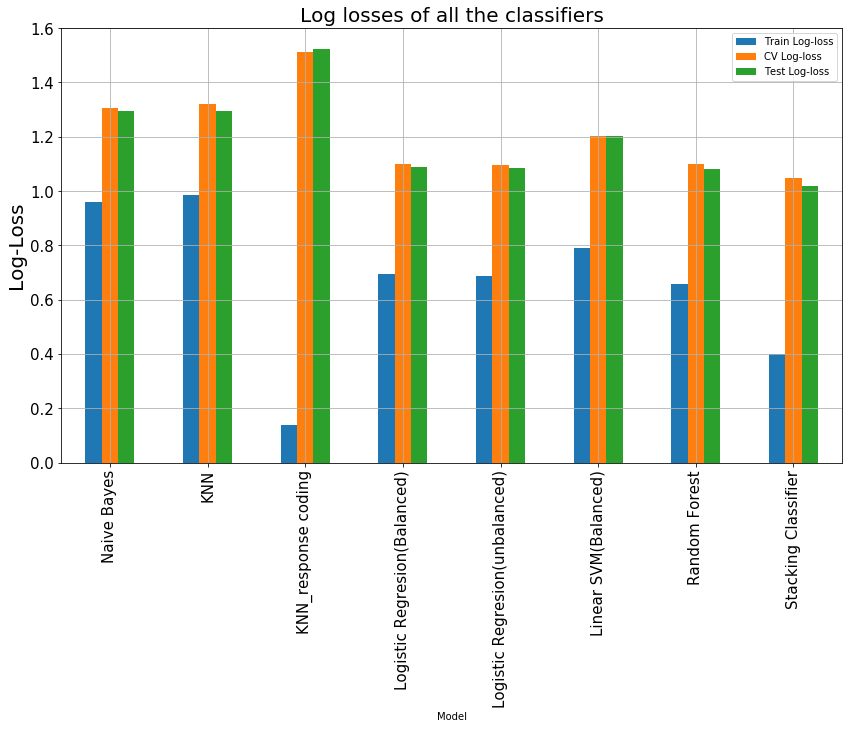

In [139]:
table2.plot(x = "Model", kind = "bar", figsize = (14, 8), grid = True, fontsize = 15)
plt.title("Log losses of all the classifiers", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()